# LSTM model evalutation exploration, updates

In [1]:
import os
import sys
import numpy as np
import pprint
import pickle as pkl
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve

%matplotlib inline
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.getenv('HOME')
                             , 'nu'
                             , 'jiping_research'
                             , 'nuclstm'
                             , 'nuclstm'))

from keras.models import load_model
from loaders import *
from train import *
from utils import *
from preprocessors import *
from evaluation import *

Using TensorFlow backend.


In [6]:
data_dir = os.path.join(os.getenv('HOME'), 'nu/jiping_research/data')
data_file = 'seq_ncp_positions_unique_map.feather'
model_dir = '../model_output/gru_binary_sequence__052818_144741'
config_file = '../nuclstm/model_configs/gru_binary_sequence_config.json'
model_file = 'model_epoch_711.h5'
# model_dir = '../model_output/lstm_binary_sequence__050618_095517/'
# config_file = '../nuclstm/model_configs/lstm_binary_sequence_config.json'
# model_file = 'model_epoch_1999.h5'

train_chroms = [1, 2, 3, 4, 5]
test_chroms = [7, 8]
all_chroms = train_chroms + test_chroms

loader = NcpLoader(data_dir)
nuc_df = loader.load(data_file
                     , chromosomes=all_chroms)

params = ConfigLoader(config_file).load()

print('Model configuration:')
pprint.pprint(params)
m = load_model(os.path.join(model_dir, model_file))

print('\n\nModel architecture:')
m.summary()

Model configuration:
{'data_params': {'batch_size': 128,
                 'lookback': 1000,
                 'no_one_class_samples': False,
                 'output_len': 1000,
                 'shuffle': False,
                 'shuffle_between': False,
                 'step_size': 1000,
                 'target_position': 'all'},
 'model_params': {'class_weight': None,
                  'dense_params': {'activation': 'sigmoid',
                                   'hidden_units': 1,
                                   'regularization': {0: 0.0},
                                   'timedistributed': True},
                  'early_stopping': 3,
                  'epochs': 1000,
                  'final_layer_activation': 'sigmoid',
                  'rnn_params': {'activation': 'tanh',
                                 'bidirectional': True,
                                 'dropout': {0: 0.2, 1: 0.2},
                                 'flavor': 'gru',
                                 'hi

Class balance of nucleosome vector pre-processing: 0.5612038620321292
Class balance of nucleosome vector post-processing: 11.785281102674713


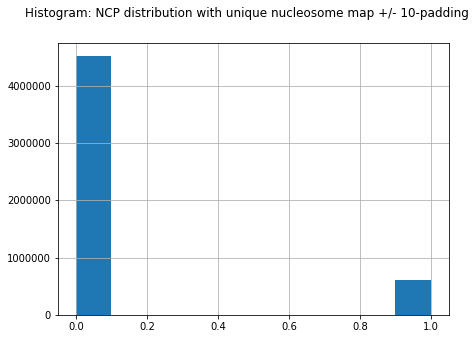

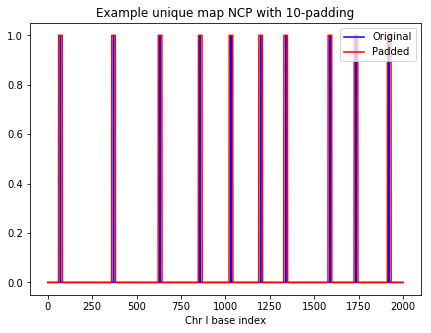

In [3]:
print('Class balance of nucleosome vector pre-processing: {0}'
      .format(nuc_df['nucleosome'].mean()*100))

nuc_df = preprocess_by_chromosome(nuc_df
                                  , target=params['model_params']['target']
                                  , method=params['preprocessor_params']['target']['method']
                                  , pad_len=params['preprocessor_params']['target']['pad_len'])
TARGET = 'nucleosome_padded'

# plot distribution of padded NCP map
nuc_df[TARGET].hist(figsize=(7, 5))
plt.suptitle('Histogram: NCP distribution with unique nucleosome map +/- ' + 
             str(params['preprocessor_params']['target']['pad_len']) + '-padding')

# plot original NCP map and padded map
fig = plt.figure(figsize=(7, 5))
plt.plot(np.arange(0, 2000), nuc_df['nucleosome'].iloc[0:2000], 'b-', label='Original')
plt.plot(np.arange(0, 2000, ), nuc_df[TARGET].iloc[0:2000], 'r-', label='Padded')
plt.title('Example unique map NCP with ' + str(params['preprocessor_params']['target']['pad_len']) + '-padding')
plt.legend(loc='upper right')
plt.xlabel('Chr I base index')

print('Class balance of nucleosome vector post-processing: {0}'
      .format(nuc_df[TARGET].mean()*100))

In [ ]:
from IPython.display import Image
Image(os.path.join(model_dir, 'training_progress.png'))

## Evaluation: performance on a held-out chromosome - Chr VII and VIII

In the code below, we iterate over 10 batches of data from a hold-out chromosome. Each batch contains 128 consecutive 1000-base scans of the chromosome, and each scan is run through the model. So, each scan results in predicted probabilities for 1000 base positions. 100 batches will give us 10 x 128 x 1000 = 1,280,000 base index positions. Again, the output is on a probability scale.

We can evaluate this model using traditional binary classification metrics such as ROC AUC, precision and recall, etc., in addition to simply plotting predicted probability and actual 0/1 nucleosome position occupancy as a function of base position. The plots below are randomly sampled sections across chromosomes VII and VIII with their predicted probability of NCP proximity.

In [4]:
# test_gen = gen_seq_scans(loader.subset_to_chromosomes(nuc_df, test_chroms)
test_gen = gen_seq_scans(loader.subset_to_chromosomes(nuc_df, test_chroms[0])
                         , lookback=params['data_params']['lookback']
                         , batch_size=params['data_params']['batch_size']
                         , target=TARGET
                         , target_position=params['data_params']['target_position']
                         , shuffle=False
                         , step_size=params['data_params']['lookback']
                         , flatten_final_target_dim=False
                         , no_one_class_samples=False
                         , testing=True)

y_test, y_preds, y_idx = extract_preds_from_generator(test_gen
                                                      , model=m
                                                      , n_pos=50000)

tab = np.unique(y_test, return_counts=True)
print('Test set composition:')
print(tab)

Test set composition:
(array([ 0.,  1.]), array([112481,  15519]))


In [ ]:
start = 6000
base_step = 20000

plot_genome_predictions(y_test
                        , preds=y_preds
                        , start=start
                        , base_step=base_step
                        , fname=os.path.join(model_dir, 'preds_plot.png'))

In [ ]:
pr_plot(y_test
        , preds=y_preds
        , verbose=False
        , fname=os.path.join(model_dir, 'precision_recall.png'))

In [ ]:
roc_plot(y_test
         , preds=y_preds
         , verbose=False
         , fname=os.path.join(model_dir, 'roc.png'))

In [ ]:
pd.set_option('display.max_rows', 500)

chr7_df = loader.subset_to_chromosomes(nuc_df, chromosomes=7)


preds_df = pd.DataFrame({'preds': y_preds})

# preds_sum is supposed to act like occupancy probability. How to normalize though?
preds_df['preds_sum'] = preds_df['preds'].rolling(window=params['preprocessor_params']['target']['pad_len']*2 + 147
                                                  , center=True
                                                  , min_periods=params['preprocessor_params']['target']['pad_len']*2 + 147).sum()
preds_df['preds_smoothed'] = smooth_signal(preds_df['preds'].values
                                           , smooth_window_len=147
                                           , smooth_window='hanning')
ncpnoise_smoothed = smooth_signal(chr7_df['NCP/noise'].values[0:preds_df.shape[0]]
                                  , smooth_window_len=147
                                  , smooth_window='hanning')

fig, axes = plt.subplots(2, 2, figsize=[14, 10])
axes[0, 0].plot(preds_df['preds'].iloc[0:2000], 'r-')
axes[0, 0].plot(y_test[0:2000], 'b-')
axes[0, 0].plot(chr7_df['NCP/noise'].values[0:2000], 'g-')

axes[0, 1].plot(preds_df['preds'].iloc[0:2000], 'r-')
axes[0, 1].plot(preds_df['preds_smoothed'].iloc[0:2000], 'm-')
axes[0, 1].plot(y_test[0:2000], 'b-')

axes[1, 0].plot(y_test[0:2000], 'b-')
axes[1, 0].plot(chr7_df['NCP/noise'].values[0:2000], 'g-')
axes[1, 0].plot(preds_df['preds_smoothed'].iloc[0:2000], 'm-')

max_scale = np.nanmax(preds_df['preds_sum'].values[0:2000])
min_scale = np.nanmin(preds_df['preds_sum'].values[0:2000])
axes[1, 1].plot(preds_df['preds_sum'].values[0:2000], 'r-')
axes[1, 1].plot(y_test[0:2000]*np.nanmax(preds_df['preds_sum'].values[0:2000]), 'b-')
axes[1, 1].plot(((ncpnoise_smoothed[0:2000] - np.min(ncpnoise_smoothed[0:2000]))/
                (np.max(ncpnoise_smoothed[0:2000]) - np.min(ncpnoise_smoothed[0:2000])))*max_scale, 'g-')

In [5]:
from postprocessors import *

test_df = loader.subset_to_chromosomes(nuc_df, test_chroms[0])
test_df.head()

preds_df = DataFrame({'nuclstm_preds': y_preds
                              , 'idx': y_idx})
preds_df.drop_duplicates(subset=['idx']
                         , inplace=True)

test_df.loc[:, 'idx'] = list(range(test_df.shape[0]))
test_df = test_df.merge(preds_df
                        , on=['idx'])
test_df.drop(['idx']
             , axis=1
             , inplace=True)

test_df = locate_nucleosome_centers(test_df
                                    , pred_col='nuclstm_preds'
                                    , min_sep=127
                                   , min_max=0.5)

test_df = preprocess_by_chromosome(test_df
                                  , target='NCP/noise'
                                  , method='smooth'
                                  , smooth_window_len=147
                                  , smooth_window='hanning')

/Users/fineiskid/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/fineiskid/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


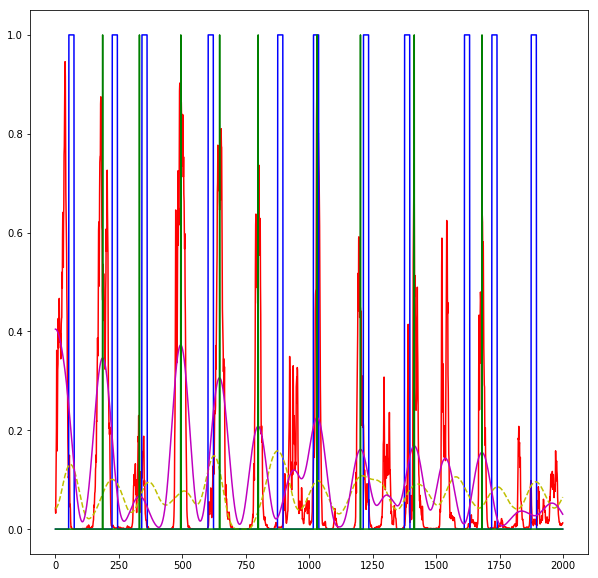

In [14]:
fig, axes = plt.subplots(1, 1, figsize=[10, 10])
axes.plot(test_df['nuclstm_preds'].iloc[0:2000], 'r-')
axes.plot(test_df['nucleosome_padded'].iloc[0:2000], 'b-')
axes.plot(test_df['NCP/noise_smoothed'].iloc[0:2000], 'y--')
axes.plot(test_df['nuclstm_preds_smoothed'].iloc[0:2000], 'm-')
axes.plot(test_df['nuclstm_ncp'].iloc[0:2000], 'g-')

In [49]:
df = pd.read_csv('/Users/fineiskid/nu/jiping_research/model_output/testing/gru_binary_sequence__051618_224741/test_data_chr_7.csv')
n_nupop_nucs = df['nupop_ncp'].sum()
n_nuclstm_nucs = df['nuclstm_ncp'].sum()
n_nucs = df['nucleosome'].sum()

print('Nuclstm number of nucleosomes: {0}'.format(n_nuclstm_nucs))
print('NuPoP number of nucleosomes: {0}'.format(n_nupop_nucs))
print('Unique map number of nucleosomes: {0}'.format(n_nucs))

Nuclstm number of nucleosomes: 5171
NuPoP number of nucleosomes: 4736
Unique map number of nucleosomes: 6099.0


In [79]:
from keras.models import Sequential
from keras import optimizers, initializers, regularizers
from keras.layers import *

mdl = Sequential()
mdl.add(LSTM(32
             , dropout=0.2
             , recurrent_dropout=0.2
             , batch_input_shape=(128, 10, 4)
            , return_sequences=True
            , kernel_regularizer=regularizers.l1(0.002)))

mdl.add(TimeDistributed(Dense(1
                              , activation='sigmoid'
                              , use_bias=True
                             , kernel_regularizer=regularizers.l1(0.002))))
mdl.compile(loss='binary_crossentropy', optimizer=optimizers.Adam())
mdl.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (128, 10, 32)             4736      
_________________________________________________________________
time_distributed_6 (TimeDist (128, 10, 1)              33        
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________


In [9]:
test_chrom = 9
test_df = pd.read_csv(os.path.join(model_dir, 'test_data_chr_' + str(test_chrom) + '.csv'))

In [19]:
test_df[['Chr', 'pos', 'nuclstm_preds_smoothed']].to_csv(os.path.join(model_dir, 'gbrowser', 'chr_9_nuclstm_preds.txt')
                                                        , sep = ' '
                                                        , header = None
                                                        , index = None)

,Chr,pos,seq,Watson,Crick,NCP,NCP/noise,nucleosome,nucleosome_padded,nuclstm_preds,NCP/noise_smoothed,nuclstm_preds_smoothed,nuclstm_ncp,P-start,Occup,N/L,Affinity,nupop_ncp
0,chrIX,1,C,28.0,0.0,0.0,0.0,0.0,0.0,0.114660,0.147030,0.271533,0,0.000,0.000,0,NaN,0
1,chrIX,2,A,11.0,0.0,0.0,0.0,0.0,0.0,0.140967,0.146978,0.271522,0,0.031,0.031,0,NaN,0
2,chrIX,3,C,12.0,0.0,0.0,0.0,0.0,0.0,0.135353,0.146823,0.271486,0,0.006,0.038,0,NaN,0
3,chrIX,4,A,5.0,0.0,0.0,0.0,0.0,0.0,0.150397,0.146566,0.271427,0,0.026,0.063,0,NaN,0
4,chrIX,5,C,17.0,0.0,0.0,0.0,0.0,0.0,0.156569,0.146205,0.271344,0,0.001,0.065,0,NaN,0
